#set-ups

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd


In [ ]:
!pip install requests

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading Price Data

In [ ]:
import requests
import time

def download_bitcoin_data(lim,dte):
    # Define the URL for the API endpoint
    url = "https://min-api.cryptocompare.com/data/v2/histoday"

    # Define the parameters for the API request
    params = {
        'fsym': 'BTC',  # From symbol (Bitcoin)
        'tsym': 'USD',  # To symbol (US Dollar)
        'limit': lim,  # Total days from 1-Jan-2015 to 31-May-2021
        'toTs': int(time.mktime(time.strptime(dte, '%Y-%m-%d'))),
        'api_key': '34fa692b611dbbfdf87d6864be9b53531df46b4adcee57800fb013e1ec07e292'  # Replace with your own API key from CryptoCompare
    }

    # Send a GET request to the API
    response = requests.get(url, params=params)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert the response to JSON format
        data = response.json()
        return data
    else:
        print(f"Error: Unable to retrieve data. Status code {response.status_code}")

# Call the function to download Bitcoin data
bitcoin_data1 = download_bitcoin_data(2000,'2021-05-31')
bitcoin_data2 = download_bitcoin_data(307,'2015-04-11')

# Now 'bitcoin_data' contains the historical Bitcoin price data from 1-Jan-2015 to 31-May-2021


In [ ]:
(bitcoin_data.keys)

NameError: ignored

In [ ]:
for key in bitcoin_data1.keys():
    print(key, bitcoin_data1[key])

In [ ]:
def calculate_stochastic_oscillator(data, high_col='High', low_col='Low', close_col='Close', k_window=14, d_window=3):
    # Calculate %K
    data['Lowest_Low'] = data[low_col].rolling(window=k_window, min_periods=1).min()
    data['Highest_High'] = data[high_col].rolling(window=k_window, min_periods=1).max()
    data['%K'] = ((data[close_col] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low'])) * 100

    # Calculate %D (Simple Moving Average of %K)
    data['%D'] = data['%K'].rolling(window=d_window, min_periods=1).mean()

    # Drop auxiliary columns
    data.drop(['Lowest_Low', 'Highest_High'], axis=1, inplace=True)

    return data


In [ ]:

def calculate_mfi(data, period=14):
    # Typical Price calculation
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3

    # Raw Money Flow calculation
    raw_money_flow = typical_price * data['Volume']

    # Calculate Money Flow Ratio (MFR)
    delta = typical_price.diff()
    positive_flow = np.where(delta > 0, raw_money_flow, 0)
    negative_flow = np.where(delta < 0, -raw_money_flow, 0)

    positive_mfr = pd.Series(positive_flow).rolling(window=period, min_periods=1).sum() / \
                   pd.Series(negative_flow).rolling(window=period, min_periods=1).sum()

    # Calculate Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + positive_mfr))

    # Add the MFI values to the DataFrame
    data['MFI'] = mfi

    return data


In [ ]:

def calculate_rsi(data, column_name='Close', period=14):
    # Calculate daily price changes
    delta = data[column_name].diff()

    # Calculate gain (positive price changes) and loss (negative price changes)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the specified period
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    # Add the RSI values to the DataFrame
    data['RSI'] = rsi

    return data

In [ ]:
start_date ='2015-01-01'
end_date = '2023-11-1'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [ ]:
def get_technical_indicators(price):
    # Create 7 and 21 days Moving Average
    dataset = price.copy()

    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1

    # Create high-low spred
    dataset['spread'] = dataset['High'] - dataset['Low']
    dataset = calculate_rsi(dataset)
    # dataset = calculate_mfi(dataset)
    dataset=calculate_stochastic_oscillator(dataset)
    dataset['Next_Close'] = dataset['Close'].shift(-1)


    return dataset

The Gold etf SPDR Gold future, has a lot of NAN values.
That might cause some issues, but let's see how it goes first.

In [ ]:
 # to be finished
# def get_related_asset (price, start_date, end_date):
#     other_price = yf.download("ETH-USD", start=start_date, end=end_date)

#     price['eth']=other_price["Close"]
#     #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
#     #let's fill it with the next valid value
#     price.eth.fillna(method='bfill', inplace= True, axis=0)

#     return price

 # to be finished
def get_related_asset (price, start_date, end_date):
    other_price = yf.download("ETH-USD GLD", start=start_date, end=end_date)

    price['eth']=other_price.Close['ETH-USD']
    price['gold'] = other_price.Close['GLD']
    #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
    #let's fill it with the next valid value
    price.eth.fillna(method='bfill', inplace= True, axis=0)
    price.gold.fillna(method='bfill', inplace= True, axis=0)

    return price


In [ ]:
def get_label (price,threshold):


    price['change']=price.shift(-1).High/price.Close -1
    price['change_label']=price['change'].apply (lambda x: x> threshold)

    #convert True/False to 1/0
    class2idx = {True: 1, False:0}
    price['change_label'].replace(class2idx, inplace=True)

    return price

In [ ]:
def normalise_close(price):

    df = price.copy()
    for key in df.keys():
        if not key in ['change','change_label','Volume','MACD','20sd','spread','eth','gold']:
            df[key]=df[key]/price['Close'].shift(1) - 1

    df['Volume']=df['Volume']/price['Volume'].shift(1)-1
    df['eth']  = df['eth']/price['eth'].shift(1)-1
    df['gold'] = df['gold']/price['gold'].shift(1)-1
    df['MACD'] = df['MACD']/price['Close'].shift(1)
    df['20sd'] = df['20sd']/price['Close'].shift(1)
    df['spread'] = df['spread']/price['Close'].shift(1)



    return df


In [ ]:
def get_ma_feature (price,threshold):
    price['ma_feature']=price['ma7'].apply(lambda x: x > threshold)

    class2idx = {True: 1, False:0}
    price['ma_feature'].replace(class2idx, inplace=True)
    return price

In [ ]:
#Here I want to define a function to return a new dataframe, that's INDEPENDANT, and produce relative price.
def process_price (original_df,threshold, start_date,end_date):
    #get the indicators
    df = get_technical_indicators(original_df)

    #get related asset
    df = get_related_asset(df,start_date,end_date)

    #get label
    df = get_label(df, threshold)

    #normalise the data
    df_normalised_close = normalise_close(df)

    #get ma label
    df_normalised_close = get_ma_feature(df_normalised_close, threshold)

    #return both normalized, and un-normalized data (w/o ma label).
    return df, df_normalised_close





In [ ]:
test_df, test_df_norm = process_price(price,0.05,start_date,end_date)

[*********************100%%**********************]  2 of 2 completed


In [ ]:
# test_df["MFI"][20:50]

In [ ]:
test_df["12ema"][25:90]

Date
2015-01-26    240.402576
2015-01-27    243.991637
2015-01-28    242.426828
2015-01-29    241.044590
2015-01-30    238.780343
                 ...    
2015-03-27    259.078337
2015-03-28    258.112131
2015-03-29    255.743033
2015-03-30    254.478874
2015-03-31    252.901200
Name: 12ema, Length: 65, dtype: float64

In [ ]:
test_df["26ema"][25:90]

Date
2015-01-26    241.926951
2015-01-27    243.751514
2015-01-28    242.927351
2015-01-29    242.146147
2015-01-30    240.853121
                 ...    
2015-03-27    262.763653
2015-03-28    262.024543
2015-03-29    260.592418
2015-03-30    259.623509
2015-03-31    258.481684
Name: 26ema, Length: 65, dtype: float64

In [ ]:
test_df.reset_index(inplace = True)


#Plots

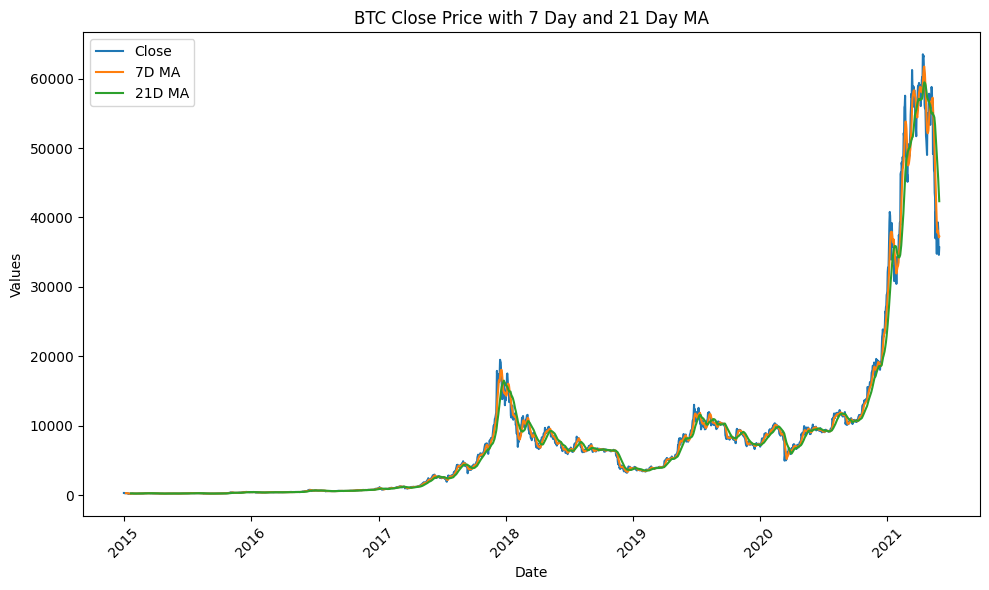

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'][], test_df['Close'], label='Close')
plt.plot(test_df['Date'], test_df['ma7'], label='7D MA')
plt.plot(test_df['Date'], test_df['ma21'], label='21D MA')

# Add title and labels
plt.title('BTC Close Price with 7 Day and 21 Day MA')
plt.xlabel('Date')
plt.ylabel('Values')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


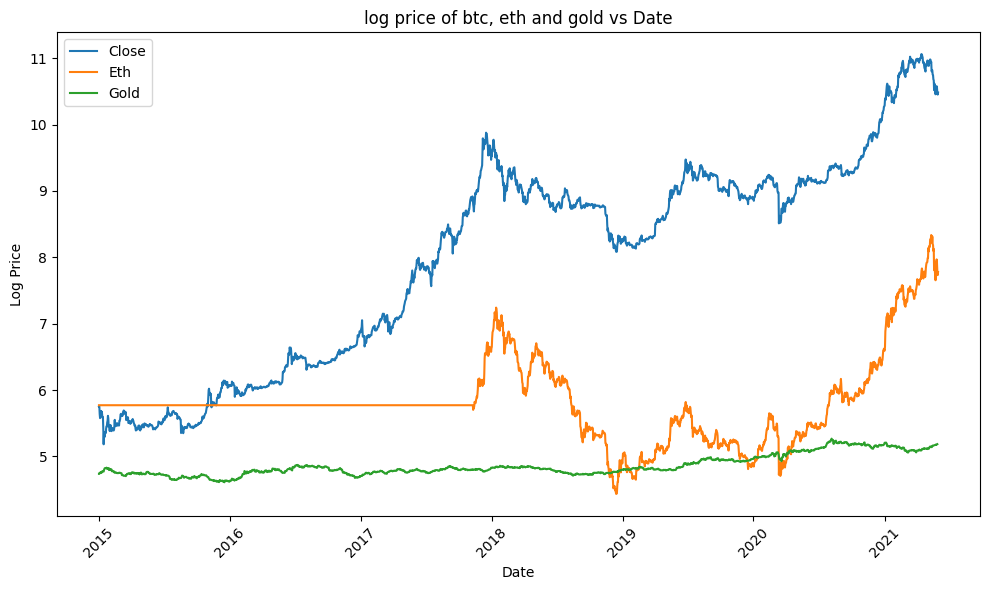

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'],np.log(test_df['Close']), label='Close')
plt.plot(test_df['Date'], np.log(test_df['eth']), label='Eth')
plt.plot(test_df['Date'], np.log(test_df['gold']), label='Gold')

# Add title and labels
plt.title('log price of btc, eth and gold vs Date')
plt.xlabel('Date')
plt.ylabel('Log Price')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


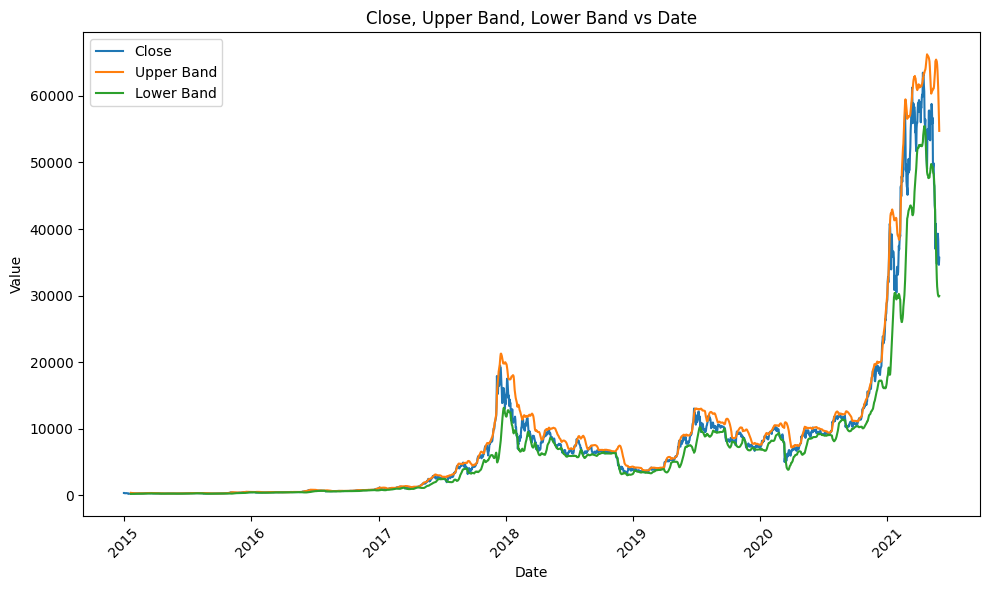

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'],(test_df['Close']), label='Close')
plt.plot(test_df['Date'], (test_df['upper_band']), label='Upper Band')
plt.plot(test_df['Date'], (test_df['lower_band']), label='Lower Band')

# Add title and labels
plt.title('Close, Upper Band, Lower Band vs Date')
plt.xlabel('Date')
plt.ylabel('Value')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


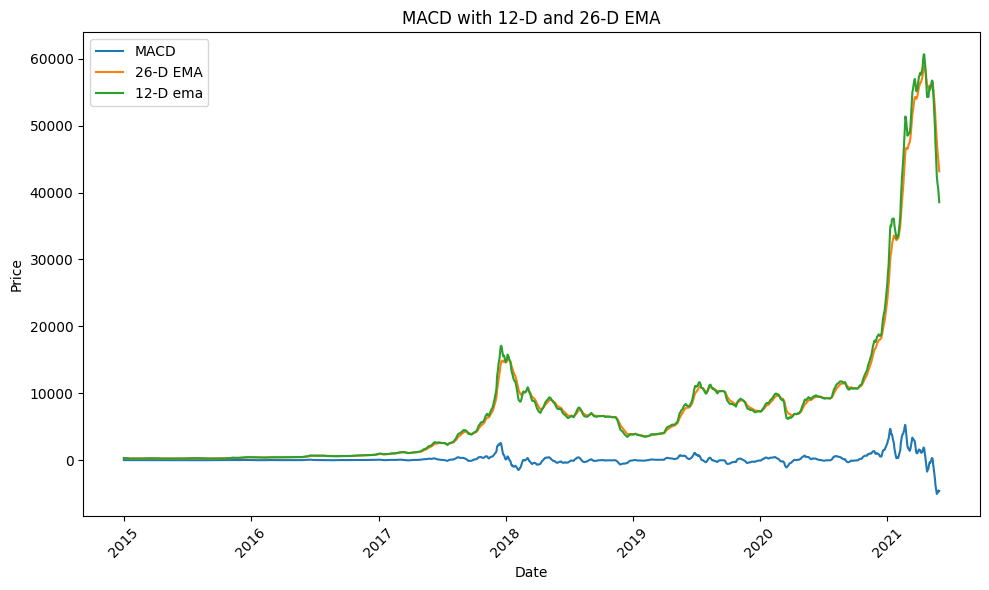

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'],(test_df['MACD']), label='MACD')
plt.plot(test_df['Date'], (test_df['26ema']), label='26-D EMA')
plt.plot(test_df['Date'], (test_df['12ema']), label='12-D ema')

# Add title and labels
plt.title('MACD with 12-D and 26-D EMA')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


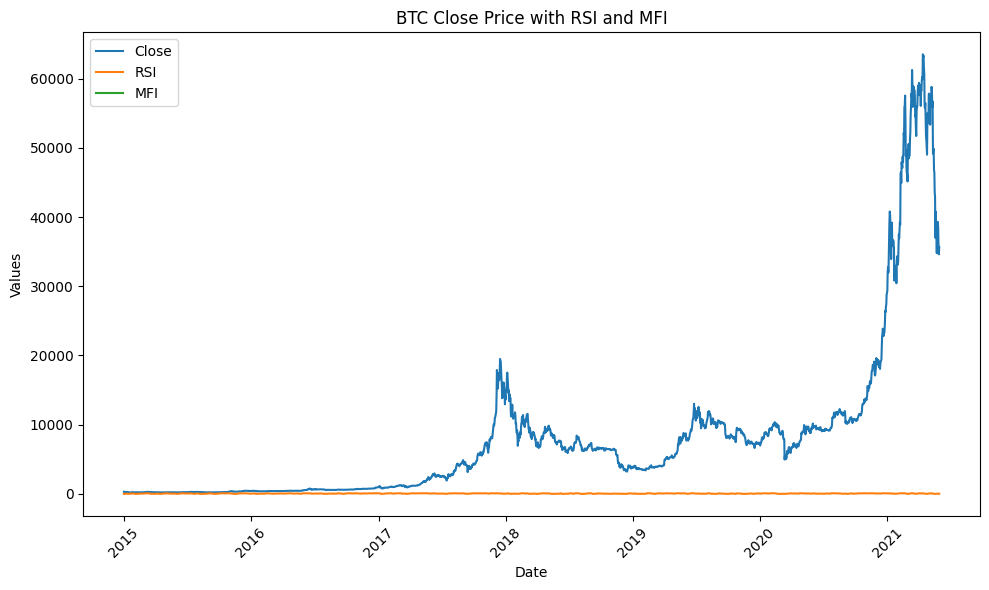

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'], test_df['Close'], label='Close')
plt.plot(test_df['Date'], test_df['%D'], label='RSI')
plt.plot(test_df['Date'], test_df['MFI'], label='MFI')

# Add title and labels
plt.title('BTC Close Price with RSI and MFI')
plt.xlabel('Date')
plt.ylabel('Values')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


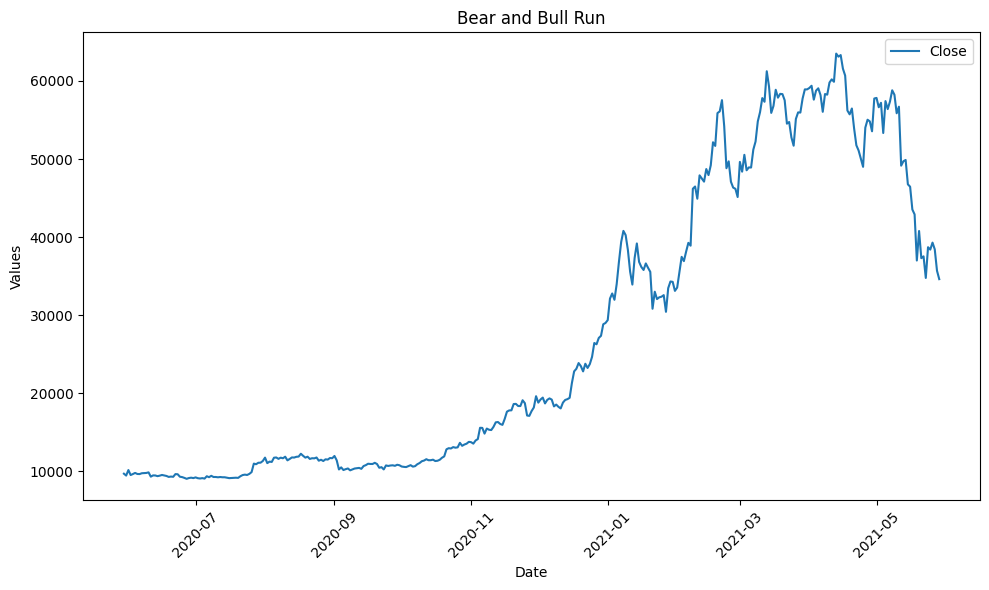

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Make sure your 'Date' column is in datetime format, if not, convert it using df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))

# Plot the columns
plt.plot(test_df['Date'][len(test_df)-366:len(test_df)-1], test_df['Close'][len(test_df)-366:len(test_df)-1], label='Close')

# Add title and labels
plt.title('Bear and Bull Run')
plt.xlabel('Date')
plt.ylabel('Values')

# Add legend
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
w = (test_df_norm["change"])

In [ ]:
srt = w.to_numpy()

In [ ]:
srt.sort()

In [ ]:
for i in srt:
  print(i)

-0.008708875393138804
-0.007854382194197651
-0.007765750030301222
-0.0064404442096738235
-0.006324919992382161
-0.005548488770184767
-0.00497987607079764
-0.004305664097003059
-0.0035841827301144047
-0.003122276432769633
-0.0030815814013815945
-0.0024172759200892235
-0.0019588037670398295
-0.0018217175657236906
-0.0017239139136158155
-0.001623000670829211
-0.0015847114406499774
-0.0015291426822241494
-0.0014652002238435546
-0.001313990242732821
-0.0011567807383924267
-0.0011046035642401364
-0.0009882271066520287
-0.0009851591006805327
-0.0009780476305580876
-0.0009284626102372684
-0.0008783448861710008
-0.0008145052295617239
-0.0007854003097053086
-0.0007062632645358224
-0.0006862740523814193
-0.0006692849083218544
-0.0006640091673273396
-0.0006620412823391542
-0.0005919558143144821
-0.0005757649903695983
-0.00055202991846659
-0.0005485879390004778
-0.0005406359707486041
-0.0005220394256099103
-0.0005175870996138032
-0.0005052953932095372
-0.0004908392021887309
-0.0004724350350838735
-

In [ ]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-0.008709,0
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,-0.007854,0
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,-0.007766,0
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,-0.006440,0
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-0.006325,0


In [ ]:
test_df_norm.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005060,0,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,...,NaN,NaN,NaN,0.001869,0.007236,0.0,0.000000,0.000375,0,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,...,NaN,NaN,NaN,-0.074799,0.108141,0.0,0.015077,0.021873,0,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,...,NaN,NaN,NaN,-0.028544,0.105371,0.0,0.000000,0.053544,0,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,...,NaN,NaN,NaN,0.037136,0.050179,0.0,0.000000,0.047651,0,0


In [ ]:
test_df_norm.change_label.value_counts()

0    2342
Name: change_label, dtype: int64

# Some analysis with MA only

In [ ]:
(test_df_norm['change_label']==test_df_norm['ma_feature']).value_counts()

True     2003
False    1223
dtype: int64

In [ ]:
test_df_norm['change_label'].value_counts()

0    2031
1    1195
Name: change_label, dtype: int64

In [ ]:
#7day ma feature

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest.

accuracy: 0.6208927464352139
[[1694  337]
 [ 886  309]]
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      2031
           1       0.48      0.26      0.34      1195

    accuracy                           0.62      3226
   macro avg       0.57      0.55      0.54      3226
weighted avg       0.59      0.62      0.59      3226



In [ ]:
#for 21day ma features

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.15, but recall is higher.

accuracy: 0.6208927464352139
[[1694  337]
 [ 886  309]]
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      2031
           1       0.48      0.26      0.34      1195

    accuracy                           0.62      3226
   macro avg       0.57      0.55      0.54      3226
weighted avg       0.59      0.62      0.59      3226



In [ ]:
#for ema features

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest.

accuracy: 0.6208927464352139
[[1694  337]
 [ 886  309]]
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      2031
           1       0.48      0.26      0.34      1195

    accuracy                           0.62      3226
   macro avg       0.57      0.55      0.54      3226
weighted avg       0.59      0.62      0.59      3226



In [ ]:
#so bascially 7day ma works best among these 3. got it.


# Format Custom Dataset input for Torch Models

Creating two dataset classes for future use, 1 is for classification tast, the other for Regression task

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change_label.values
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that
        #df = df.drop (['change'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).long()





In [ ]:
class RegressionDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change.values
        df = df.drop (['change','change_label'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).float()



In [ ]:
# define a function for train_test split, and initiate dataset?
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
train_dataset = ClassifierDataset(test_df_train)
eval_dataset = ClassifierDataset (test_df_eval)

In [ ]:
test_df_eval.values

array([[-8.51878311e-04,  4.66721654e-02, -1.25464907e-02, ...,
         8.64656539e-03,  0.00000000e+00,  0.00000000e+00],
       [-2.64885731e-03,  8.64656539e-03, -2.51626311e-02, ...,
         3.71126034e-02,  0.00000000e+00,  0.00000000e+00],
       [ 3.25905209e-03,  3.71126034e-02, -1.21186605e-02, ...,
         2.30373758e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.45009066e-04,  1.49453108e-02, -4.36634689e-04, ...,
         2.67775716e-02,  0.00000000e+00,  0.00000000e+00],
       [-4.68398326e-05,  2.67775716e-02, -5.20976372e-03, ...,
         4.33421682e-03,  0.00000000e+00,  0.00000000e+00],
       [-3.20624292e-04,  4.33421682e-03, -1.97159600e-02, ...,
                    nan,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
test_df_eval.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,-0.000852,0.046672,-0.012546,0.035761,0.035761,-0.081727,-0.020675,0.003487,0.037342,-0.002200,...,0.041315,0.086117,-0.079144,0.022630,0.059219,0.047209,0.000000,0.008647,0,0
2018-07-03,-0.002649,0.008647,-0.025163,-0.012789,-0.012789,0.062630,-0.045072,-0.031539,0.000467,-0.032979,...,0.040083,0.048626,-0.111705,-0.012752,0.033809,-0.023461,0.010131,0.037113,0,0
2018-07-04,0.003259,0.037113,-0.012119,0.010408,0.010408,-0.106076,-0.023065,-0.017187,0.013204,-0.015704,...,0.040054,0.062922,-0.097296,0.006951,0.049231,0.006728,0.003371,0.023037,0,0
2018-07-05,0.000327,0.023037,-0.007715,0.006304,0.006304,0.196938,-0.017198,-0.027572,0.003029,-0.020897,...,0.040407,0.053243,-0.108387,0.003062,0.030752,0.015180,0.000000,0.009308,0,0
2018-07-06,-0.000068,0.009308,-0.015904,0.005175,0.005175,-0.137077,-0.013560,-0.032108,-0.002630,-0.022076,...,0.040864,0.049620,-0.113836,0.002376,0.025213,-0.000843,-0.001596,0.028544,0,0


In [ ]:
# for Regression dataset construction

# test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
# train_dataset = RegressionDataset(test_df_train)
# eval_dataset = RegressionDataset (test_df_eval)

In [ ]:
eval_dataset.X

tensor([[-8.5188e-04,  4.6672e-02, -1.2546e-02,  ...,  4.7209e-02,
          0.0000e+00,  0.0000e+00],
        [-2.6489e-03,  8.6466e-03, -2.5163e-02,  ..., -2.3461e-02,
          1.0131e-02,  0.0000e+00],
        [ 3.2591e-03,  3.7113e-02, -1.2119e-02,  ...,  6.7277e-03,
          3.3713e-03,  0.0000e+00],
        ...,
        [-1.1406e-04,  1.7207e-02, -6.7734e-03,  ...,  6.7535e-03,
         -3.5119e-04,  0.0000e+00],
        [-1.4501e-04,  1.4945e-02, -4.3663e-04,  ...,  8.7105e-03,
          2.1078e-03,  0.0000e+00],
        [-4.6840e-05,  2.6778e-02, -5.2098e-03,  ...,  5.0149e-02,
          0.0000e+00,  0.0000e+00]])

In [ ]:
train_dataset.df.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005060,0,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,...,NaN,NaN,NaN,0.001869,0.007236,0.0,0.000000,0.000375,0,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,...,NaN,NaN,NaN,-0.074799,0.108141,0.0,0.015077,0.021873,0,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,...,NaN,NaN,NaN,-0.028544,0.105371,0.0,0.000000,0.053544,1,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,...,NaN,NaN,NaN,0.037136,0.050179,0.0,0.000000,0.047651,0,0


In [ ]:
train_dataset[1]

(tensor([ 0.0019,  0.0446, -0.0020,  0.0287,  0.0287,  0.1210, -0.0530,  0.0945,
          0.0443, -0.0017, -0.0460,  0.1607,  0.4160, -0.2269,  0.0117,  0.0467,
          0.0000,  0.0080,  0.0000]),
 tensor(0))

# Format DataLoader, different sampling options

In [ ]:
#Now let's try to flow the data into dataloader
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

The above is the normal dataloader. Below I will try to use weighted samplers, which will include oversample and undersamples, and in this case, it will also disrupt the ordering/sequence of the input, ummmmmmmmmmm, How will that affect the model performance, let's seeeeeeeee

In [ ]:
#obtain the label list.
target_list = []
for _,t in train_dataset:
  target_list.append(t)




In [ ]:
#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
class_weight

tensor([0.0009, 0.0062])

In [ ]:
#a weight for each sample
class_weights_all = class_weight[target_list]

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
for i, batch in enumerate(train_loader):
    _,t = (m for m in batch)
    print (sum(t)/len(t))

tensor(0.5312)
tensor(0.4531)
tensor(0.3750)
tensor(0.3906)
tensor(0.6562)
tensor(0.5938)
tensor(0.6562)
tensor(0.5781)
tensor(0.4062)
tensor(0.5938)
tensor(0.6094)
tensor(0.5000)
tensor(0.5156)
tensor(0.4375)
tensor(0.5312)
tensor(0.4062)
tensor(0.4844)
tensor(0.4688)
tensor(0.6250)
tensor(0.6667)


In [ ]:
#next(iter(train_loader))

In [ ]:
# for i, batch in enumerate(train_loader):
#     print (i)

In [ ]:
#weighed random sampler test.

# import torch
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
# train_dataset = torch.tensor([1, 1 , 1, 1, 1, 1, 1, 1, 1, 0])


# class_weights_all = [0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.9]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=10,
#     replacement=True #if True, sampler will draw repeating inputs, False will have 0 repeats.
# )

# BATCH_SIZE = 5
# dataset = TensorDataset(train_dataset)
# train_loader = DataLoader(dataset,
#                           batch_size=BATCH_SIZE,
#                           sampler=weighted_sampler
# )
# for batch in train_loader:
#     print(batch)

#Format Dataset and DataLoader for LSTM

In [ ]:
class LSTMDataset(Dataset):
    def __init__(self,df,window_size):
        self.df = df
        self.window_size = window_size
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change_label.values[self.window_size:]
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that
        #df = df.drop (['change'],axis=1)
        x_values = df.values
        output = self.process(x_values)


        return torch.tensor(output,dtype=torch.float), torch.from_numpy(y_values).long()

    def process(self,data):
        output = []
        for i in range(self.window_size-1, len(data)):
            raw_data = data[i-self.window_size+1:i+1]
            output.append(raw_data)
        return output



In [ ]:
# define a function for train_test split, and initiate dataset?
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
WINDOW_SIZE = 10
train_dataset = LSTMDataset(test_df_train, window_size=WINDOW_SIZE)
eval_dataset = LSTMDataset (test_df_eval, window_size= WINDOW_SIZE)

<ipython-input-41-91cf3ff06750>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(output,dtype=torch.float), torch.from_numpy(y_values).long()


In [ ]:
train_dataset[0]

(tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  7.3738e-02,  7.3738e-02,
           2.4421e-01,  9.5185e-04,  1.9347e-01,  1.2295e-01,  6.5804e-02,
          -5.7147e-02,  1.8713e-01,  5.6772e-01, -1.8079e-01,  4.9743e-02,
           7.8442e-02,  0.0000e+00,  2.4160e-04,  0.0000e+00],
         [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  2.8687e-02,  2.8687e-02,
           1.2097e-01, -5.2953e-02,  9.4539e-02,  4.4277e-02, -1.6947e-03,
          -4.5971e-02,  1.6074e-01,  4.1603e-01, -2.2695e-01,  1.1676e-02,
           4.6651e-02,  0.0000e+00,  8.0496e-03,  0.0000e+00],
         [ 4.7553e-04,  6.1652e-03, -3.5175e-02, -2.2579e-03, -2.2579e-03,
          -2.6600e-01, -6.4195e-02,  4.7255e-02,  1.3600e-02, -2.5246e-02,
          -3.8846e-02,  1.5229e-01,  3.5183e-01, -2.5732e-01, -7.0176e-03,
           4.1340e-02,  0.0000e+00, -7.9853e-03,  0.0000e+00],
         [-7.6864e-04,  6.5833e-02, -1.2268e-02,  6.4274e-02,  6.4274e-02,
           6.5308e-03, -3.2272e-02,  4.2829e-02,  2.0149e-02,

In [ ]:
#a vanilla dataloader

train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )


In [ ]:
#weighted_dataloader

#obtain the label list.
target_list = []
for _,t in train_dataset:
  target_list.append(t)

#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)


#a weight for each sample
class_weights_all = class_weight[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
#train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
next(iter(train_loader))

[tensor([[[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  0.0000e+00,
            2.4160e-04,  0.0000e+00],
          [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          ...,
          [-4.7061e-04,  1.1614e-02, -1.3826e-01,  ...,  0.0000e+00,
           -7.8778e-03,  0.0000e+00],
          [-2.4239e-03,  2.0482e-02, -5.6444e-02,  ...,  0.0000e+00,
           -2.1552e-02,  1.0000e+00],
          [-3.1733e-03,  3.9989e-02, -3.2863e-02,  ...,  0.0000e+00,
            2.2276e-02,  1.0000e+00]],
 
         [[ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          [-7.6864e-04,  6.5833e-02, -1.2268e-02,  ...,  0.0000e+00,
           -9.9815e-03,  0.0000e+00],
          ...,
    



# Torch Model 1 - FeedForward Classification

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class.

        return out_dist



In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 273,922 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m


In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)




In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 5

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       480
           1       0.25      0.19      0.22        67

    accuracy                           0.83       547
   macro avg       0.57      0.56      0.56       547
weighted avg       0.81      0.83      0.82       547

 Epoch Number 0
 Train. Loss: 0.678 Train. Acc: 55.99%
 Eval loss , 0.589, eval acc, 83.45 %
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       478
           1       0.29      0.22      0.25        69

    accuracy                           0.84       547
   macro avg       0.59      0.57      0.58       547
weighted avg       0.82      0.84      0.82       547

 Epoch Number 1
 Train. Loss: 0.618 Train. Acc: 67.00%
 Eval loss , 0.471, eval acc, 83.80 %
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       448
           1       0.33      0.17      0.23        

In [ ]:
# #obtain the label list.
# target_list = []
# for _,t in eval_dataset:
#   target_list.append(t)

# #obtain the class weights
# leng = len(target_list)
# total_true = sum(target_list)
# class_count = [leng-total_true, total_true]
# class_count

In [ ]:
# for step,batch in enumerate(eval_loader):

#     data,label = (t for t in batch)
#     data = data.to(device)
#     label = label.to(device)

#     pred = model(data)
#     loss = loss_fn(pred,label)
#     acc = accuracy(pred,label)
#     report = get_cfm(pred,label)

#     epoch_loss += loss.item()
#     epoch_acc += acc



In [ ]:
    # pred_list =[]
    # label_list =[]
    # for step,batch in enumerate(eval_loader):
    #     data,label = (t for t in batch)
    #     data = data.to(device)
    #     label = label.to(device)

    #     pred = model(data)
    #     loss = loss_fn(pred,label)
    #     acc = accuracy(pred,label)
    #     if step ==0:
    #         pred_list=pred.cpu().detach().numpy()
    #         label_list = label.cpu().detach().numpy()
    #     if step != 0:
    #         pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
    #         label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



    # report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    # print (report)


In [ ]:
target = torch.empty(3).random_(2)
target

tensor([0., 0., 1.])

# Torch Model 1.1 - FeedForward with CE

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)
         #why is it -1, ok, coz it's batch x input x class.

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)




In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)


        epoch_loss += loss.item()


    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)

    eval_loss = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} ')
    print (f' Eval loss , {eval_loss:.3f} ')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

 Epoch Number 0
 Train. Loss: 0.664 
 Eval loss , 0.591 
 Epoch Number 1
 Train. Loss: 0.622 
 Eval loss , 0.504 
 Epoch Number 2
 Train. Loss: 0.617 
 Eval loss , 0.569 
 Epoch Number 3
 Train. Loss: 0.579 
 Eval loss , 0.488 
 Epoch Number 4
 Train. Loss: 0.601 
 Eval loss , 0.527 
 Epoch Number 5
 Train. Loss: 0.573 
 Eval loss , 0.472 
 Epoch Number 6
 Train. Loss: 0.603 
 Eval loss , 0.544 
 Epoch Number 7
 Train. Loss: 0.581 
 Eval loss , 0.543 
 Epoch Number 8
 Train. Loss: 0.602 
 Eval loss , 0.536 
 Epoch Number 9
 Train. Loss: 0.585 
 Eval loss , 0.487 


# Torch Model 2 - Feedforward Classification with F1 loss function

In [ ]:
#let's first try a simple FC NN
class FFNN_F1 (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN_F1(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

model


FFNN_F1(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 273,922 trainable parameters


In [ ]:
#define optimizer, loss function
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors

    The original implmentation is written by Michal Haltuf on Kaggle.

    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1

    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()


params = model.parameters()
optimizer = optim.Adam(params)
loss_fn =F1_Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

print (device)

cuda


In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       474
           1       0.27      0.19      0.23        73

    accuracy                           0.82       547
   macro avg       0.58      0.56      0.56       547
weighted avg       0.80      0.82      0.81       547

 Epoch Number 0
 Train. Loss: 0.481 Train. Acc: 57.39%
 Eval loss , 0.571, eval acc, 82.76 %
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       444
           1       0.39      0.19      0.26       103

    accuracy                           0.79       547
   macro avg       0.61      0.56      0.57       547
weighted avg       0.75      0.79      0.76       547

 Epoch Number 1
 Train. Loss: 0.427 Train. Acc: 62.00%
 Eval loss , 0.521, eval acc, 79.63 %
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       383
           1       0.55      0.17      0.26       1

# Torch Model 3 - Feedforward Regresssion

In [ ]:
#let's first try a simple FC NN
class FFNN_regression (nn.Module):
    def __init__(self, input_size,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,1)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out



In [ ]:
#try initiating the model
INPUT_SIZE = 18
NUM_HIDDEN = 4
HIDDEN_DIM = 1024

model = FFNN_regression(INPUT_SIZE, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0

    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)


        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 20

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)
    eval_loss = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.5f} ')
    print (f' Eval loss , {eval_loss:.5f} ')


 Epoch Number 0
 Train. Loss: 0.01819 
 Eval loss , 0.01586 
 Epoch Number 1
 Train. Loss: 0.01819 
 Eval loss , 0.01614 
 Epoch Number 2
 Train. Loss: 0.01786 
 Eval loss , 0.01623 
 Epoch Number 3
 Train. Loss: 0.01790 
 Eval loss , 0.01642 
 Epoch Number 4
 Train. Loss: 0.01800 
 Eval loss , 0.01593 
 Epoch Number 5
 Train. Loss: 0.01772 
 Eval loss , 0.01546 
 Epoch Number 6
 Train. Loss: 0.01777 
 Eval loss , 0.01570 
 Epoch Number 7
 Train. Loss: 0.01737 
 Eval loss , 0.01564 
 Epoch Number 8
 Train. Loss: 0.01764 
 Eval loss , 0.01640 
 Epoch Number 9
 Train. Loss: 0.01744 
 Eval loss , 0.01590 
 Epoch Number 10
 Train. Loss: 0.01722 
 Eval loss , 0.01566 
 Epoch Number 11
 Train. Loss: 0.01740 
 Eval loss , 0.01632 
 Epoch Number 12
 Train. Loss: 0.01794 
 Eval loss , 0.01632 
 Epoch Number 13
 Train. Loss: 0.01759 
 Eval loss , 0.01537 
 Epoch Number 14
 Train. Loss: 0.01768 
 Eval loss , 0.01596 
 Epoch Number 15
 Train. Loss: 0.01705 
 Eval loss , 0.01582 
 Epoch Number 16
 

The loss seems way too small??? am I calculating it correctly???
I'm going to use L1loss instead of L2 loss and see how it goes.
It seems that the class imbalance is too dominant, I'll have to work around it.

In [ ]:
for i,batch in enumerate(train_loader):
    data,label = (t for t in batch)
    print (i)
    break

0


In [ ]:
data

tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  7.8442e-02,
          0.0000e+00,  0.0000e+00],
        [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  4.6651e-02,
          0.0000e+00,  0.0000e+00],
        [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  4.1340e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [-2.4258e-04,  3.4845e-02, -2.3194e-02,  ...,  5.8039e-02,
          0.0000e+00,  0.0000e+00],
        [-6.1106e-04,  9.8598e-04, -8.4670e-02,  ...,  8.5656e-02,
          0.0000e+00,  0.0000e+00],
        [ 7.6427e-03,  1.4638e-02, -3.6971e-02,  ...,  5.1609e-02,
          0.0000e+00,  1.0000e+00]])

In [ ]:
label

tensor([ 0.0446,  0.0062,  0.0658,  0.0292,  0.2194,  0.0073,  0.0116,  0.0205,
         0.0400,  0.0313,  0.0649,  0.0670,  0.0324,  0.0123,  0.0553,  0.0617,
         0.0361,  0.0074,  0.0025,  0.0077,  0.0162,  0.0138,  0.0834,  0.1036,
         0.0322,  0.0200,  0.0510,  0.0026,  0.0269,  0.0284,  0.0473,  0.0076,
         0.0175,  0.0042,  0.0025,  0.0010,  0.0856,  0.0034,  0.0291,  0.0619,
         0.0367,  0.0090,  0.0314,  0.0052,  0.0188,  0.0058,  0.0669,  0.0360,
         0.0193,  0.0024,  0.0005,  0.0035,  0.0165,  0.0270,  0.0061, -0.0006,
         0.0310,  0.0150,  0.0017,  0.0374,  0.0348,  0.0010,  0.0146,  0.0331])

In [ ]:
model(data.to(device)).squeeze()

tensor([0.0306, 0.0253, 0.0240, 0.0256, 0.0248, 0.0387, 0.0230, 0.0273, 0.0294,
        0.0302, 0.0312, 0.0329, 0.0207, 0.0208, 0.0152, 0.0203, 0.0126, 0.0092,
        0.0113, 0.0096, 0.0081, 0.0083, 0.0082, 0.0177, 0.0202, 0.0215, 0.0082,
        0.0101, 0.0153, 0.0084, 0.0109, 0.0119, 0.0129, 0.0082, 0.0082, 0.0078,
        0.0074, 0.0177, 0.0110, 0.0160, 0.0200, 0.0211, 0.0205, 0.0203, 0.0196,
        0.0192, 0.0197, 0.0226, 0.0210, 0.0200, 0.0206, 0.0205, 0.0193, 0.0161,
        0.0170, 0.0176, 0.0211, 0.0222, 0.0179, 0.0064, 0.0064, 0.0088, 0.0134,
        0.0227], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
loss_fn(model(data.to(device)).squeeze(),label.to(device))

tensor(0.0214, device='cuda:0', grad_fn=<L1LossBackward>)

#Torch Model 4 - LSTM Classification

The previous 3 models used the almost the same dataloader because the similar input format, for LSTM I will need to make some adjustments. And perhaps try out 2 scenarios with and w/o the weighted sampler.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, num_classes,  num_hidden, hidden_dim):
        super().__init__()
        #num_layers = num_layers
        # self.input_size = input_size
        # self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_dim, num_hidden, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout()

        #need to change the loss function.
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        return self.ff(hn)

In [ ]:
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = LSTMModel(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
model

LSTMModel(
  (lstm): LSTM(19, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,193,858 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
#loss_fn = nn.NLLLoss()
loss_fn= FocalLoss(gamma=0,alpha=0.2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 15

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1219
           1       0.03      0.14      0.04        29

    accuracy                           0.85      1248
   macro avg       0.50      0.50      0.48      1248
weighted avg       0.95      0.85      0.90      1248

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       537
           1       0.00      0.00      0.00         0

    accuracy                           0.91       537
   macro avg       0.50      0.45      0.48       537
weighted avg       1.00      0.91      0.95       537

 Epoch Number 0
 Train. Loss: 0.191 Train. Acc: 85.70%
 Eval loss , 0.170, eval acc, 90.88 %
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1248
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1248
   macro avg       0.50      0.44  

why is the loss negative here, did I mess up with the NLLloss? I passed the softmax into the NLLloss correctly ya?
Ah, because i used softmax, it should be log_softmax instead.

 what about the actual result here. maybe try a few more epochs?

 The results is not exactly stable ?
 It's actually a common theme, throughout all the 4 models though .

 Hard to say, the recall of true label is not very good in evaluation set, although the accuracy is going up. The recall rate in trainning set seems decent though. ummm.

 What if I want to focus on the recall rate, maybe the focal loss could come into play here ???? maybe it can address the class imbalance better than over/undersampling?

# Torch Model 5 - Feedforward with Focal Loss


Now that I understand a little bit more about Cross-entropy and the concept of focal loss, let me try it out on the most basic network and see if it works.

In [ ]:
#first, define focal loss?
#there are a few variations...let's try

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
loss_fn = FocalLoss(gamma=0, alpha=0.2)


In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m




In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 20

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       547
           1       0.00      0.00      0.00         0

    accuracy                           0.91       547
   macro avg       0.50      0.45      0.48       547
weighted avg       1.00      0.91      0.95       547

 Epoch Number 0
 Train. Loss: 0.210 Train. Acc: 83.39%
 Eval loss , 0.156, eval acc, 90.71 %
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       498
           1       0.18      0.18      0.18        49

    accuracy                           0.85       547
   macro avg       0.55      0.55      0.55       547
weighted avg       0.85      0.85      0.85       547

 Epoch Number 1
 Train. Loss: 0.183 Train. Acc: 82.53%
 Eval loss , 0.164, eval acc, 85.19 %
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       502
           1       0.14      0.16      0.15        

In [ ]:
a = torch.range(1,6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


In [ ]:
a

tensor([1., 2., 3., 4., 5., 6.])

# Torch Model 6 -  SVM and PCA

In [ ]:
test_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,ema,spread,RSI,%K,%D,Next_Close,eth,gold,change,change_label
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,...,314.248993,6.432007,NaN,3.824657,3.824657,315.032013,320.884003,114.080002,0.005060,0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,...,314.836258,2.273987,100.000000,21.353880,12.589268,281.082001,320.884003,114.080002,0.000375,0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,...,291.467926,34.067993,2.254396,0.000000,8.392846,264.195007,320.884003,115.800003,0.021873,0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,...,273.058706,29.618011,1.516892,10.478659,10.610846,274.473999,320.884003,115.800003,0.053544,1
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,...,274.006134,13.256989,17.871062,26.840488,12.439716,286.188995,320.884003,115.800003,0.047651,0


In [ ]:
print ("Shape of DataFrame: ", test_df.shape)

Shape of DataFrame:  (3226, 25)


<ipython-input-233-15f57507c83c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = test_df.corr()


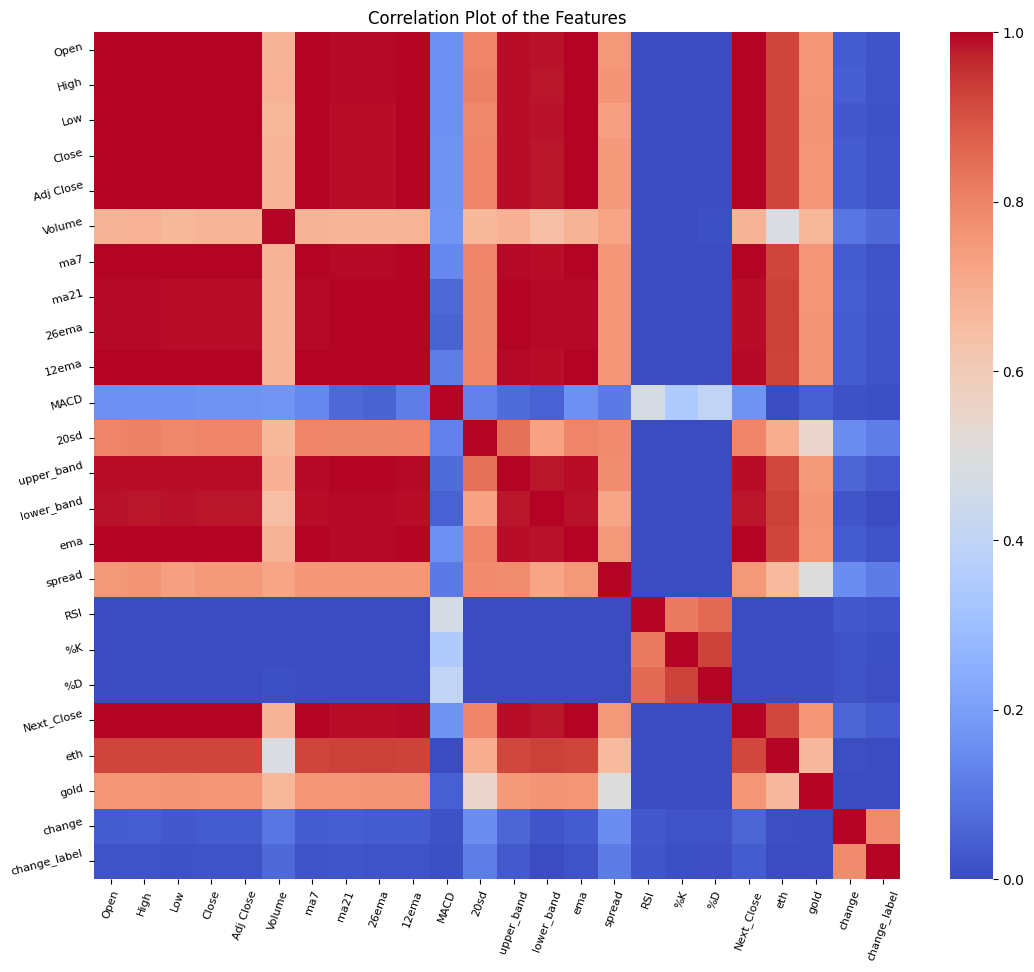

In [ ]:
corr = test_df.corr()
#fig = plt.figure()
#plt.subplot(1, 2, 1)
fig=plt.figure(figsize=(13,11))
g1 = sns.heatmap(corr, cmap='coolwarm', vmin=0, vmax=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=70, fontsize=8)
g1.set_yticklabels(g1.get_yticklabels(), rotation=15, fontsize=8)
plt.title("Correlation Plot of the Features")
plt.savefig("Corr_Features.png", dpi=200)
plt.show()

In [ ]:
print(corr)

                  Open      High       Low     Close  Adj Close    Volume  \
Open          1.000000  0.999393  0.998777  0.998562   0.998562  0.790681   
High          0.999393  1.000000  0.998697  0.999370   0.999370  0.792933   
Low           0.998777  0.998697  1.000000  0.999239   0.999239  0.784552   
Close         0.998562  0.999370  0.999239  1.000000   1.000000  0.789351   
Adj Close     0.998562  0.999370  0.999239  1.000000   1.000000  0.789351   
Volume        0.790681  0.792933  0.784552  0.789351   0.789351  1.000000   
ma7           0.998337  0.998161  0.996969  0.997218   0.997218  0.792032   
ma21          0.990663  0.990545  0.988859  0.989117   0.989117  0.781317   
26ema         0.991774  0.991594  0.990094  0.990235   0.990235  0.782685   
12ema         0.997137  0.997023  0.995721  0.995987   0.995987  0.789372   
MACD          0.423082  0.424024  0.426533  0.428490   0.428490  0.371242   
20sd          0.849321  0.854574  0.840096  0.849131   0.849131  0.709925   

In [ ]:
sns.set(font_scale=1.2)
j=sns.jointplot(test_df['Adj Close'], test_df['eth']
, kind='hex', color="#4CB391")
j.set_axis_labels('Adj Close', 'eth', fontsize=15)


TypeError: ignored

In [ ]:
j2 = sns.jointplot(test_df['Adj Close'], test_df['eth'], kind='kde', color='orange')
j2.set_axis_labels('Adj Close', 'eth', fontsize=15)


In [ ]:
X= test_df_norm.drop(columns = ['change','change_label'])
Y = test_df_norm.change_label

In [ ]:
test_df_norm["change_label"].value_counts()

0    2853
1     373
Name: change_label, dtype: int64

In [ ]:
X.tail()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-27,-0.000004,0.002388,-0.021658,-0.007227,-0.007227,-0.154894,-0.040265,-0.137687,-0.125432,-0.073297,...,-0.300742,-0.005022,0.024046,-0.997339,-0.997508,-0.997406,-0.001964,-0.013300,0.011630,0
2023-10-28,-0.000061,0.014438,-0.001032,0.005302,0.005302,-0.381148,-0.015706,-0.122815,-0.109853,-0.055497,...,-0.295944,0.004275,0.015470,-0.997314,-0.997426,-0.997438,0.018540,-0.001925,-0.005641,0
2023-10-29,-0.000006,0.019176,-0.004166,0.013168,0.013168,0.098421,-0.001852,-0.118216,-0.105087,-0.049147,...,-0.297961,0.008438,0.023341,-0.997324,-0.997290,-0.997411,0.012109,0.010654,0.000000,0
2023-10-30,-0.000195,0.008844,-0.012378,-0.001046,-0.001046,0.539817,-0.008968,-0.120138,-0.108150,-0.052204,...,-0.301641,-0.002253,0.021222,-0.997416,-0.997371,-0.997390,0.003744,0.008099,0.000000,0
2023-10-31,-0.000066,0.006286,-0.012146,0.004794,0.004794,-0.083014,-0.004758,-0.109174,-0.098919,-0.042596,...,-0.291145,0.002793,0.018432,-0.997372,-0.997302,-0.997331,NaN,0.003519,-0.005457,0


In [ ]:
print(Y[1])

0


In [ ]:
df = test_df.fillna(0)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
for column in test_df.columns:
    if column != 'Next_Close':  # Skip the 'Next_Close' column itself
        correlation_coefficient, p_value = pearsonr(df['Next_Close'], df[column])
        print(f"Pearson Correlation Coefficient between 'Next_Close' and '{column}': {correlation_coefficient:.4f}")
        print(f"P-value: {p_value}\n")

Pearson Correlation Coefficient between 'Next_Close' and 'Open': 0.9969
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'High': 0.9976
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'Low': 0.9973
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'Close': 0.9981
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'Adj Close': 0.9981
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'Volume': 0.6796
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'ma7': 0.9957
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'ma21': 0.9896
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and '26ema': 0.9900
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and '12ema': 0.9948
P-value: 0.0

Pearson Correlation Coefficient between 'Next_Close' and 'MACD': 0.1640
P-value: 6.837992254758287e-21

Pearson Correlation Coeffici

In [ ]:
X.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,...,NaN,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,...,NaN,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,...,NaN,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,...,NaN,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
X.tail()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-27,-0.000004,0.002388,-0.021658,-0.007227,-0.007227,-0.154894,-0.040265,-0.137687,-0.125432,-0.073297,...,-0.300742,-0.005022,0.024046,-0.997339,-0.997508,-0.997406,-0.001964,-0.013300,0.011630,0
2023-10-28,-0.000061,0.014438,-0.001032,0.005302,0.005302,-0.381148,-0.015706,-0.122815,-0.109853,-0.055497,...,-0.295944,0.004275,0.015470,-0.997314,-0.997426,-0.997438,0.018540,-0.001925,-0.005641,0
2023-10-29,-0.000006,0.019176,-0.004166,0.013168,0.013168,0.098421,-0.001852,-0.118216,-0.105087,-0.049147,...,-0.297961,0.008438,0.023341,-0.997324,-0.997290,-0.997411,0.012109,0.010654,0.000000,0
2023-10-30,-0.000195,0.008844,-0.012378,-0.001046,-0.001046,0.539817,-0.008968,-0.120138,-0.108150,-0.052204,...,-0.301641,-0.002253,0.021222,-0.997416,-0.997371,-0.997390,0.003744,0.008099,0.000000,0
2023-10-31,-0.000066,0.006286,-0.012146,0.004794,0.004794,-0.083014,-0.004758,-0.109174,-0.098919,-0.042596,...,-0.291145,0.002793,0.018432,-0.997372,-0.997302,-0.997331,NaN,0.003519,-0.005457,0


In [ ]:
print(len(X))

3226


In [ ]:
X.reset_index(inplace = True)

In [ ]:
X.fillna(0,inplace=True)

In [ ]:
startidx = X[X["Date"] == "2023-01-01"].index[0]
print(startidx)

2922


In [ ]:
X.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.0,0.0,0.001294,...,0.0,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.0,0.0,-0.039485,...,0.0,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.0,0.0,0.038339,...,0.0,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.0,0.0,0.089449,...,0.0,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
X_train = X[:2922]
X_test = X[2922:]
Y_train = Y[:2922]
Y_test = Y[2922:]

In [ ]:
Y_train.head()

Date
2015-01-01    0
2015-01-02    0
2015-01-03    0
2015-01-04    1
2015-01-05    0
Name: change_label, dtype: int64

In [ ]:
#test_df2=test_df.drop(['change','change_label'])
# X_train, X_test, Y_train, Y_test = train_test_split(test_df.drop(['change','change_label'],axis =1 ), test_df.change_label, test_size=0.25,
#                                                     stratify=test_df.change_label, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (2922, 24)
test feature shape:  (304, 24)


In [ ]:
X_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.0,0.0,0.001294,...,0.0,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.0,0.0,-0.039485,...,0.0,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.0,0.0,0.038339,...,0.0,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.0,0.0,0.089449,...,0.0,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
print(len(Y_train))

2922


#now PCA.

In [ ]:
X_train.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
ma7           0
ma21          0
26ema         0
12ema         0
MACD          0
20sd          0
upper_band    0
lower_band    0
ema           0
spread        0
RSI           0
%K            0
%D            0
Next_Close    0
eth           0
gold          0
ma_feature    0
dtype: int64

In [ ]:
# X_train_drop = X_train.dropna()

In [ ]:
X_train.reset_index(inplace = True)

In [ ]:
X_train.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.0,0.0,...,0.0,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2,2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.0,0.0,...,0.0,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
3,3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.0,0.0,...,0.0,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
4,4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.0,0.0,...,0.0,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
X_train.drop(columns = ["index"], inplace = True)

<ipython-input-554-2b1031b882a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ["index"], inplace = True)


In [ ]:
naInd = []

In [ ]:
for i in range(len(X_train)):
  if(X_train.iloc[i][:].isna().any()):
    naInd.append(i)

In [ ]:
naInd

[]

In [ ]:
s=(X_train.columns)

In [ ]:
X_train_drop = pd.DataFrame(columns=s)
Y_train_drop = []


In [ ]:
X_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.0,0.0,0.001294,...,0.0,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.0,0.0,-0.039485,...,0.0,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.0,0.0,0.038339,...,0.0,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.0,0.0,0.089449,...,0.0,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
X_train

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.000000,0.000000,0.001294,...,0.000000,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.000000,0.000000,0
2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.000000,0.000000,-0.039485,...,0.000000,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.000000,0.015077,0
3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.000000,0.000000,0.038339,...,0.000000,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.000000,0.000000,0
4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.000000,0.000000,0.089449,...,0.000000,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2022-12-27,-0.000030,0.002367,-0.016415,-0.011976,-0.011976,0.324862,-0.005632,0.004554,0.002776,...,-0.036895,-0.008513,0.018781,-0.998234,-0.999018,-0.998682,-0.021704,-0.011559,0.000000,0
2918,2022-12-28,-0.000046,0.003051,-0.013137,-0.009846,-0.009846,0.079825,0.004156,0.015888,0.013095,...,-0.027200,-0.005396,0.016188,-0.998371,-0.999362,-0.998915,-0.004476,-0.018804,-0.004506,0
2919,2022-12-29,-0.000015,0.005992,-0.002651,0.005423,0.005423,-0.148978,0.012519,0.024290,0.021855,...,-0.019831,0.005114,0.008644,-0.997884,-0.998668,-0.999007,0.003022,0.009756,0.005598,0
2920,2022-12-30,-0.000061,0.000065,-0.014053,-0.002389,-0.002389,0.100670,0.005389,0.017247,0.014956,...,-0.027242,-0.001695,0.014118,-0.997073,-0.998002,-0.998679,-0.005699,-0.001966,0.004679,0


In [ ]:
Y_train_index = Y_train.index.to_list()

In [ ]:
print(len(Y_train),len(Y_train_index))

2922 2922


In [ ]:
Y_train_index_drop = []
Y_train_drop = []

In [ ]:
for i in range(len(X_train)):
  if i in naInd:
    continue
  else:
    X_train_drop = X_train_drop.append(X_train.loc[i], ignore_index=True)
    Y_train_drop.append(Y_train[i])
    Y_train_index_drop.append(Y_train_index[i])


<ipython-input-565-9f86d37af0e2>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_drop = X_train_drop.append(X_train.loc[i], ignore_index=True)


In [ ]:
X_train_drop.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
0,2015-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
1,2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,0.0,0.0,0.001294,...,0.0,0.001869,0.007236,-0.681781,-0.932048,-0.959939,-0.105544,0.0,0.000000,0
2,2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,0.0,0.0,-0.039485,...,0.0,-0.074799,0.108141,-0.992844,-1.000000,-0.973359,-0.161371,0.0,0.015077,0
3,2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,0.0,0.0,0.038339,...,0.0,-0.028544,0.105371,-0.994603,-0.962720,-0.962250,-0.023509,0.0,0.000000,0
4,2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,0.0,0.0,0.089449,...,0.0,0.037136,0.050179,-0.932357,-0.898407,-0.952915,0.083249,0.0,0.000000,0


In [ ]:
X_train_drop.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
ma7           0
ma21          0
26ema         0
12ema         0
MACD          0
20sd          0
upper_band    0
lower_band    0
ema           0
spread        0
RSI           0
%K            0
%D            0
Next_Close    0
eth           0
gold          0
ma_feature    0
dtype: int64

In [ ]:
X_train_drop_noDate = X_train_drop.drop(columns=["Date"])

In [ ]:
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability = True))
# clf.fit(X_train_drop_noDate,Y_train_drop)

In [ ]:
# Y_test.reset_index(inplace = True)

In [ ]:
X_test_dropDate = X_test.reset_index()


In [ ]:
X_test_dropDate.drop("Date",inplace = True,axis =1 )

In [ ]:
X_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
2922,2023-01-01,0.000025,0.005012,-0.001587,0.004689,0.004689,-0.177488,0.006687,0.020026,0.018157,...,-0.025091,0.003573,0.006599,-0.997217,-0.997769,-0.998097,0.008519,0.003504,0.000000,0
2923,2023-01-02,0.000026,0.008076,-0.003179,0.003813,0.003813,0.308665,0.000001,0.013782,0.012695,...,-0.022976,0.002172,0.011255,-0.996469,-0.997214,-0.997844,0.003295,0.011401,0.000000,0
2924,2023-01-03,0.000023,0.004313,-0.003961,-0.000516,-0.000516,0.149226,-0.004117,0.006789,0.008155,...,-0.016380,-0.000889,0.008274,-0.997703,-0.997051,-0.997355,0.010472,0.000101,0.000000,0
2925,2023-01-04,0.000021,0.017070,-0.000725,0.010994,0.010994,0.325012,-0.000942,0.004589,0.008847,...,-0.011294,0.007205,0.017795,-0.996874,-0.995097,-0.996457,0.009405,0.034367,0.009412,0
2926,2023-01-05,0.000014,0.001232,-0.004326,-0.001572,-0.001572,-0.256707,-0.010159,-0.007826,-0.002083,...,-0.023638,-0.002297,0.005559,-0.997017,-0.995433,-0.995888,0.005262,-0.004845,-0.012451,0


In [ ]:
X_test_drop = pd.DataFrame(columns=s)
Y_test_drop = []
naIndTest = []

In [ ]:
for i in range(len(X_test_dropDate)):
  if(X_test.iloc[i][:].isna().any()):
    naIndTest.append(i)

In [ ]:
for i in range(len(X_test_dropDate)):
  if i in naIndTest:
    continue
  else:
    X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
    Y_test_drop.append(Y_test[i])


<ipython-input-576-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-576-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-576-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-576-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-inp

In [ ]:
X_test_drop.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature,index
0,NaN,0.000025,0.005012,-0.001587,0.004689,0.004689,-0.177488,0.006687,0.020026,0.018157,...,0.003573,0.006599,-0.997217,-0.997769,-0.998097,0.008519,0.003504,0.000000,0.0,2922.0
1,NaN,0.000026,0.008076,-0.003179,0.003813,0.003813,0.308665,0.000001,0.013782,0.012695,...,0.002172,0.011255,-0.996469,-0.997214,-0.997844,0.003295,0.011401,0.000000,0.0,2923.0
2,NaN,0.000023,0.004313,-0.003961,-0.000516,-0.000516,0.149226,-0.004117,0.006789,0.008155,...,-0.000889,0.008274,-0.997703,-0.997051,-0.997355,0.010472,0.000101,0.000000,0.0,2924.0
3,NaN,0.000021,0.017070,-0.000725,0.010994,0.010994,0.325012,-0.000942,0.004589,0.008847,...,0.007205,0.017795,-0.996874,-0.995097,-0.996457,0.009405,0.034367,0.009412,0.0,2925.0
4,NaN,0.000014,0.001232,-0.004326,-0.001572,-0.001572,-0.256707,-0.010159,-0.007826,-0.002083,...,-0.002297,0.005559,-0.997017,-0.995433,-0.995888,0.005262,-0.004845,-0.012451,0.0,2926.0


In [ ]:
len(X_test_drop)

304

In [ ]:
X_test_drop.drop(columns = ["Date"], inplace = True) # This is the ifnal

In [ ]:
X_test_drop.isna().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
ma7           0
ma21          0
26ema         0
12ema         0
MACD          0
20sd          0
upper_band    0
lower_band    0
ema           0
spread        0
RSI           0
%K            0
%D            0
Next_Close    0
eth           0
gold          0
ma_feature    0
index         0
dtype: int64

In [ ]:
# Y_pred_probs = clf.predict_proba(X_test_drop)

In [ ]:

# print(Y_test_drop)

In [ ]:
X_test_drop.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature,index
0,0.000025,0.005012,-0.001587,0.004689,0.004689,-0.177488,0.006687,0.020026,0.018157,0.009933,...,0.003573,0.006599,-0.997217,-0.997769,-0.998097,0.008519,0.003504,0.000000,0.0,2922.0
1,0.000026,0.008076,-0.003179,0.003813,0.003813,0.308665,0.000001,0.013782,0.012695,0.005004,...,0.002172,0.011255,-0.996469,-0.997214,-0.997844,0.003295,0.011401,0.000000,0.0,2923.0
2,0.000023,0.004313,-0.003961,-0.000516,-0.000516,0.149226,-0.004117,0.006789,0.008155,0.000924,...,-0.000889,0.008274,-0.997703,-0.997051,-0.997355,0.010472,0.000101,0.000000,0.0,2924.0
3,0.000021,0.017070,-0.000725,0.010994,0.010994,0.325012,-0.000942,0.004589,0.008847,0.002911,...,0.007205,0.017795,-0.996874,-0.995097,-0.996457,0.009405,0.034367,0.009412,0.0,2925.0
4,0.000014,0.001232,-0.004326,-0.001572,-0.001572,-0.256707,-0.010159,-0.007826,-0.002083,-0.007007,...,-0.002297,0.005559,-0.997017,-0.995433,-0.995888,0.005262,-0.004845,-0.012451,0.0,2926.0


In [ ]:
def getLabel(arr):
  if(arr[0]>arr[1]):
    return 0
  return 1


In [ ]:
Y_pred = []

In [ ]:
print(Y_train_drop)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [ ]:
# print(Y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
param_grid = {'C': [0.1,0.5, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(probability = True), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_drop_noDate, Y_train_drop)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.880 total time=   1.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.880 total time=   1.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.880 total time=   1.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.880 total time=   1.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.880 total time=   1.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.880 total time=   0.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.880 total time=   0.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.880 total time=   0.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.880 total time=   0.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.880 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.880 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 0.5, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
print(grid.best_params_)


{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
X_test_drop.drop(columns = ["index"], inplace = True)

In [ ]:
X_train_drop_noDate.tail()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,lower_band,ema,spread,RSI,%K,%D,Next_Close,eth,gold,ma_feature
2917,-0.000030,0.002367,-0.016415,-0.011976,-0.011976,0.324862,-0.005632,0.004554,0.002776,-0.003320,...,-0.036895,-0.008513,0.018781,-0.998234,-0.999018,-0.998682,-0.021704,-0.011559,0.000000,0
2918,-0.000046,0.003051,-0.013137,-0.009846,-0.009846,0.079825,0.004156,0.015888,0.013095,0.005898,...,-0.027200,-0.005396,0.016188,-0.998371,-0.999362,-0.998915,-0.004476,-0.018804,-0.004506,0
2919,-0.000015,0.005992,-0.002651,0.005423,0.005423,-0.148978,0.012519,0.024290,0.021855,0.014289,...,-0.019831,0.005114,0.008644,-0.997884,-0.998668,-0.999007,0.003022,0.009756,0.005598,0
2920,-0.000061,0.000065,-0.014053,-0.002389,-0.002389,0.100670,0.005389,0.017247,0.014956,0.007094,...,-0.027242,-0.001695,0.014118,-0.997073,-0.998002,-0.998679,-0.005699,-0.001966,0.004679,0
2921,0.000066,0.001590,-0.005124,-0.003318,-0.003318,-0.294427,0.005213,0.018016,0.015852,0.007533,...,-0.027333,-0.001980,0.006714,-0.997442,-0.998537,-0.998402,0.001355,-0.002053,0.008371,0


In [ ]:
(X_test_drop["ma_feature"].value_counts())

0.0    298
1.0      6
Name: ma_feature, dtype: int64

In [ ]:
Y_pred_probs = grid.predict_proba(X_test_drop)


In [ ]:
for i in range(len(Y_pred_probs)):
  Y_pred.append(getLabel(Y_pred_probs[i]))

In [ ]:
# print(Y_pred.value_counts())

In [ ]:
# X_train_drop_noDate.head()

In [ ]:
# X_train["label"] = 0
# X_test["label"] = 0

In [ ]:
# X_train["label"] = Y_train.to_numpy()
# X_test["label"] = Y_test.to_numpy()

In [ ]:
# X_test.label.to_numpy()

In [ ]:
# X_train.to_csv("train_SVM.csv",index = False)
# # Y_train_drop.to_csv("Y_train_SVM.csv", index = False)
# X_test.to_csv("test_SVM.csv", index = False)
# # Y_test_drop.to_csv("Y_test.csv", index = False)

In [ ]:
print(len(Y_pred_probs))

304


In [ ]:
# Y_pred = []

In [ ]:
# for i in range(len(Y_pred_probs)):
#   Y_pred.append(getLabel(Y_pred_probs[i]))

In [ ]:
# Y_pred

In [ ]:
print(classification_report(Y_test_drop, Y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       281
           1       1.00      0.61      0.76        23

    accuracy                           0.97       304
   macro avg       0.98      0.80      0.87       304
weighted avg       0.97      0.97      0.97       304



In [ ]:
# pipe = Pipeline([
#     # ('scaler', StandardScaler()),  # StandardScaler as the first step
#     ('svm', SVC(probability = True))  # SVM as the second step
# ])
# grid_search = GridSearchCV(pipe, param_grid, cv=4)
# grid.fit(X_train_drop_noDate, Y_train_drop)

In [ ]:
# print(grid.best_params_)


In [ ]:
from collections import Counter
print(Counter(Y_pred))

Counter({0: 290, 1: 14})


#Backtesting strategy

In [ ]:
!pip install -U vectorbt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

import vectorbt as vbt

# Prepare data
start = '2020-06-30 UTC'  # crypto is in UTC
end = '2021-05-31 UTC'
btc_price = vbt.YFData.download('BTC-USD', start=start, end=end).get('Close')

btc_price

Date
2020-06-30 00:00:00+00:00     9137.993164
2020-07-01 00:00:00+00:00     9228.325195
2020-07-02 00:00:00+00:00     9123.410156
2020-07-03 00:00:00+00:00     9087.303711
2020-07-04 00:00:00+00:00     9132.488281
                                 ...     
2021-05-26 00:00:00+00:00    39294.199219
2021-05-27 00:00:00+00:00    38436.968750
2021-05-28 00:00:00+00:00    35697.605469
2021-05-29 00:00:00+00:00    34616.066406
2021-05-30 00:00:00+00:00    35678.128906
Freq: D, Name: Close, Length: 335, dtype: float64

In [ ]:
def MACrossover(btc_price):
  fast_ma = vbt.MA.run(btc_price, 7, short_name='fast')
  print(fast_ma)
  slow_ma = vbt.MA.run(btc_price, 21, short_name='slow')
  print(slow_ma)
  entries = fast_ma.ma_crossed_above(slow_ma)
  print(entries)
  exits = fast_ma.ma_crossed_below(slow_ma)
  pf = vbt.Portfolio.from_signals(btc_price, entries, exits)
  pf.total_return()

In [ ]:
def TASVM(btc_price,preds):
  fast_ma = vbt.MA.run(btc_price, 7, short_name='fast')
  slow_ma = vbt.MA.run(btc_price, 21, short_name='slow')
  entries = fast_ma.ma_crossed_above(slow_ma)
  exits = fast_ma.ma_crossed_below(slow_ma)
  pf = vbt.Portfolio.from_signals(btc_price, entries, exits)
  pf.total_return()

In [ ]:
MACrossover(btc_price)

MA(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7bb57aa13af0> of shape (335,)",
    "input_list": [
        "<numpy.ndarray object at 0x7bb57a8946f0> of shape (335,)"
    ],
    "input_mapper": "<numpy.ndarray object at 0x7bb57a2369d0> of shape (1,)",
    "in_output_list": [],
    "output_list": [
        "<numpy.ndarray object at 0x7bb57a897810> of shape (335, 1)"
    ],
    "param_list": [
        [
            7
        ],
        [
            false
        ]
    ],
    "mapper_list": [
        "<pandas.core.indexes.numeric.Int64Index object at 0x7bb57aa13820> of shape (1,)",
        "<pandas.core.indexes.base.Index object at 0x7bb57aa129e0> of shape (1,)"
    ],
    "short_name": "ma",
    "level_names": [
        "fast_window",
        "fast_ewm"
    ]
}))
MA(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x7bb5796f26e0> of shape (335,)",
    "input_list": [
        "<numpy.ndarray object at 0x7bb579687cf0> of sh

In [ ]:
def backtest(preds):
